# Python Group
## Lab Two: Exploring Image Data
### Wali Chaudhary, Bryce Shurts, & Alex Wright

## 1. Business Understanding

# TODO

### Citation & Acknowledgement
The Hotels Reservation dataset is liscenced under the [GNU General Public License, version 2](https://www.gnu.org/licenses/old-licenses/gpl-2.0.en.html) and was provided by Preet Viradiya on [Kaggle](https://www.kaggle.com/datasets/preetviradiya/brian-tumor-dataset).

## 2. Data Preperation

In [189]:
# Handle all imports for notebook

# Generic list pulled from last project, modify as desired
import pandas as pd
from pandas import ( DataFrame, Series )
import numpy as np
from numpy import ndarray
import os
from os import listdir
from os.path import isfile, join
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import image
import seaborn as sns
import random
from scipy.stats import zscore
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from skimage.transform import resize

In [48]:
df: DataFrame = pd.read_csv("metadata.csv")

In [49]:
df.head()

,Unnamed: 0,image,class,format,mode,shape
0,0,Cancer (1).jpg,tumor,JPEG,RGB,"(512, 512, 3)"
1,1,Cancer (1).png,tumor,PNG,L,"(300, 240)"
2,2,Cancer (1).tif,tumor,TIFF,RGB,"(256, 256, 3)"
3,3,Cancer (10).jpg,tumor,JPEG,RGB,"(512, 512, 3)"
4,4,Cancer (10).tif,tumor,TIFF,RGB,"(256, 256, 3)"


Immediately we can see that we have an unnamed title with a set of IDS, which can be safely removed

In [50]:
df.drop("Unnamed: 0", axis=1, inplace=True)
df.head()

,image,class,format,mode,shape
0,Cancer (1).jpg,tumor,JPEG,RGB,"(512, 512, 3)"
1,Cancer (1).png,tumor,PNG,L,"(300, 240)"
2,Cancer (1).tif,tumor,TIFF,RGB,"(256, 256, 3)"
3,Cancer (10).jpg,tumor,JPEG,RGB,"(512, 512, 3)"
4,Cancer (10).tif,tumor,TIFF,RGB,"(256, 256, 3)"


It looks like the images are not particularly uniform in composition. Let's investigate further.

Resolutions by count:
 (512, 512, 3)    884
(225, 225, 3)    364
(630, 630, 3)    126
(256, 256, 3)    105
(236, 236, 3)     89
(251, 201, 3)     80
(217, 232, 3)     53
(168, 300, 3)     52
(221, 228, 3)     51
(198, 150, 3)     45
(252, 200, 3)     44
(417, 428, 3)     43
(222, 227, 3)     40
(201, 173, 3)     38
(244, 206, 3)     38
(442, 442, 3)     34
(192, 192, 3)     32
(250, 201, 3)     31
(231, 218, 3)     31
(234, 215, 3)     28
Name: shape, dtype: int64


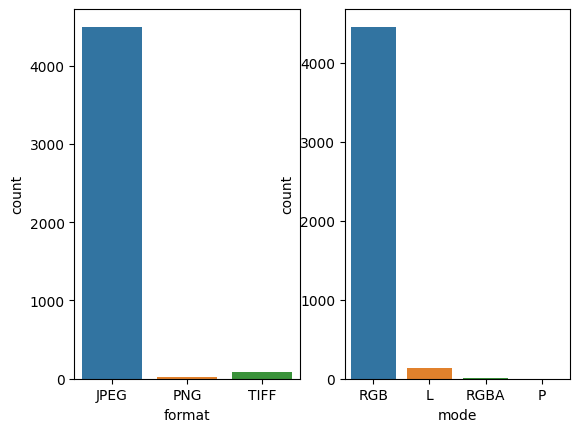

In [55]:
fig, ax = plt.subplots(1,2)
sns.countplot(x="format", data=df, ax=ax[0])
sns.countplot(x="mode", data=df, ax=ax[1])
print("Resolutions by count:\n", df["shape"].value_counts()[0:20])
# Way too many resolutions to plot...
#sns.countplot(x="shape", data=df, ax=ax[2])
plt.show()

We can see that we have a few different images that are not in the JPEG format and/or are not using the RGB color mode, which are both the most common. Since conversions would be computationally expensive and lossy, and since the number of images that are in the wrong format is relatively few, they will be dropped.
Resolutions will also be restricted to the largest square images in the top 20 most frequent resolutions, with all images to be downscaled to the smallest image to avoid losing data in trying to upscale (shown to be worse than downscaling by [this article](https://medium.com/neuronio/how-to-deal-with-image-resizing-in-deep-learning-e5177fad7d89).

In [56]:
# First we identify undesirable images
# TODO: convert RGBA to RGB?
bad_columns = df[(df["format"] != "JPEG") | (df["mode"] != "RGB") |
                 ((df["shape"] != "(630, 630, 3)")
                  & (df["shape"] != "(512, 512, 3)")
                  & (df["shape"] != "(442, 442, 3)")
                  & (df["shape"] != "(256, 256, 3)")
                  & (df["shape"] != "(236, 236, 3)")
                  & (df["shape"] != "(225, 225, 3)")
                  & (df["shape"] != "(192, 192, 3)"))]
df.drop(bad_columns.index, inplace=True)
bad_columns = bad_columns["image"] # For later deletion

In [57]:
# Then we remove images we don't want to convert or otherwise process
# We could import the images first and then delete from the numpy arrays to preserve the github dataset, but that's a lot of wasted time & space.
files = [file for file in listdir("Brain Tumor Data Set/Brain Tumor/") if isfile(join("Brain Tumor Data Set/Brain Tumor/", file))] + [file for file in listdir("Brain Tumor Data Set/Healthy/") if isfile(join("Brain Tumor Data Set/Healthy/", file))]
bad_files = [file for file in files if file in bad_columns.tolist()]
for file in bad_files:
    if "Not" in file:
        os.remove(join("Brain Tumor Data Set/Healthy/", file))
    else:
        os.remove(join("Brain Tumor Data Set/Brain Tumor/", file))

In [58]:
# Confirm we still have more than 1000 images
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1548 entries, 0 to 4585
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   image   1548 non-null   object
 1   class   1548 non-null   object
 2   format  1548 non-null   object
 3   mode    1548 non-null   object
 4   shape   1548 non-null   object
dtypes: object(5)
memory usage: 72.6+ KB


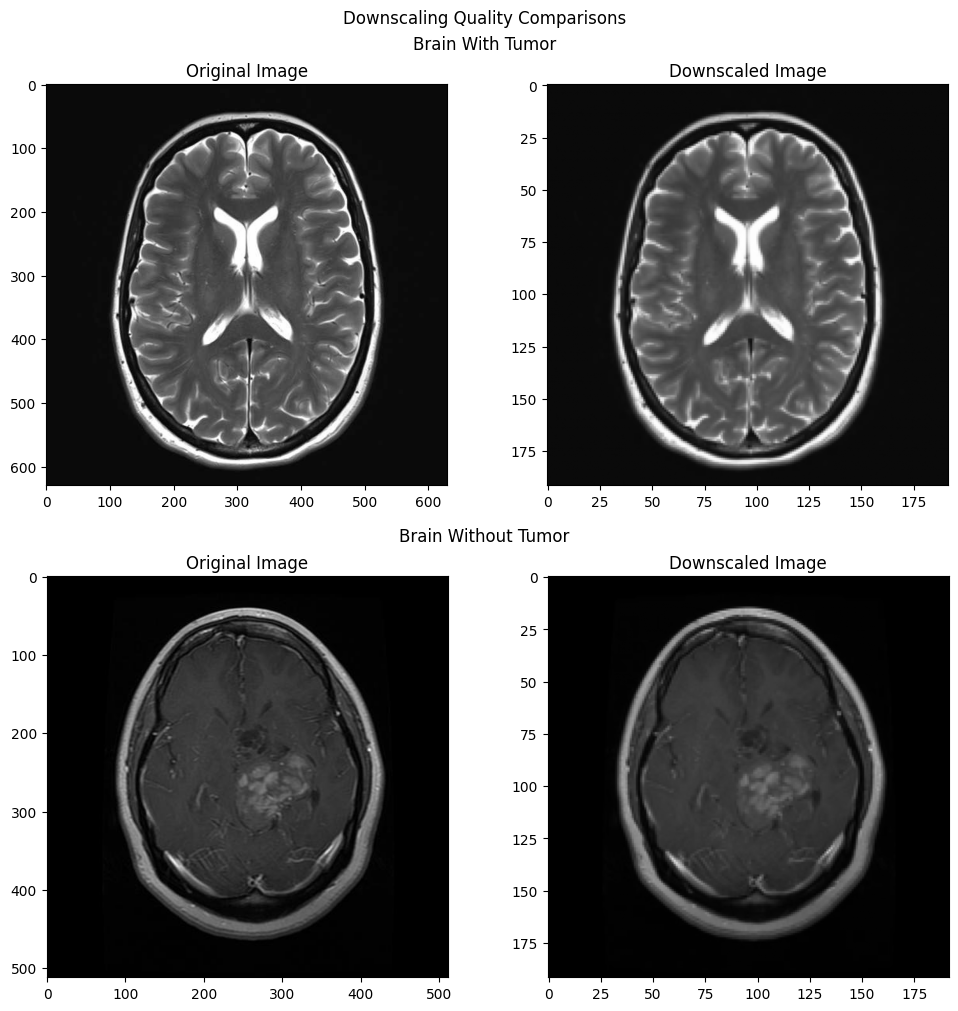

In [178]:
# Now import each image as a numpy array & do the final conversion of their resolutions
# Thoughts on what to do with resolutions? I say convert all to the smallest dimension (225x225)
cancer_images = []
healthy_images = []
original_images = [file for file in listdir("Brain Tumor Data Set/Brain Tumor/") if isfile(join("Brain Tumor Data Set/Brain Tumor/", file))] + [file for file in listdir("Brain Tumor Data Set/Healthy/") if isfile(join("Brain Tumor Data Set/Healthy/", file))]
for image in original_images:
    if "Not" in image:
        cancer_images.append(plt.imread(join("Brain Tumor Data Set/Healthy/", image)))
    else:
        healthy_images.append(plt.imread(join("Brain Tumor Data Set/Brain Tumor/", image)))

images = []
for image_set in (cancer_images, healthy_images): 
    for image in image_set:
        # Apply the resizing non-uniformly since evidently it affects images
        # even if they're the the same size as the target resolution.
        # Difference with Lienar PCA was:
        #   Applied to every image:
        #     233 components with λ > 1 for 92% explanation
        #   Applied to mis-sized images:
        #     256 components with λ > 1 for 99% explanation
        
        #images.append(resize(image, (192, 192), anti_aliasing=True).flatten())
        if len(image) != 192:
            images.append(resize(image, (192, 192), anti_aliasing=True).flatten())
        else:
            images.append(image.flatten())
images = np.array(images)

fig = plt.figure(constrained_layout=True, figsize=(10,10))
fig.suptitle("Downscaling Quality Comparisons")
subfigs = fig.subfigures(2, 1)
ax_cancer = subfigs[0].subplots(1, 2)
subfigs[0].suptitle("Brain With Tumor")
ax_cancer[0].imshow(cancer_images[0], cmap='gray')
ax_cancer[0].set_title("Original Image")
ax_cancer[1].imshow(images[0].reshape(192, 192, 3), cmap='gray')
ax_cancer[1].set_title("Downscaled Image")
ax_healthy = subfigs[1].subplots(1, 2)
subfigs[1].suptitle("Brain Without Tumor")
ax_healthy[0].imshow(healthy_images[0], cmap='gray')
ax_healthy[0].set_title("Original Image")
ax_healthy[1].imshow(images[len(cancer_images)].reshape(192, 192, 3), cmap='gray')
ax_healthy[1].set_title("Downscaled Image")
plt.show()

In [61]:
# Further preprocessing?

## 3. Data Reduction

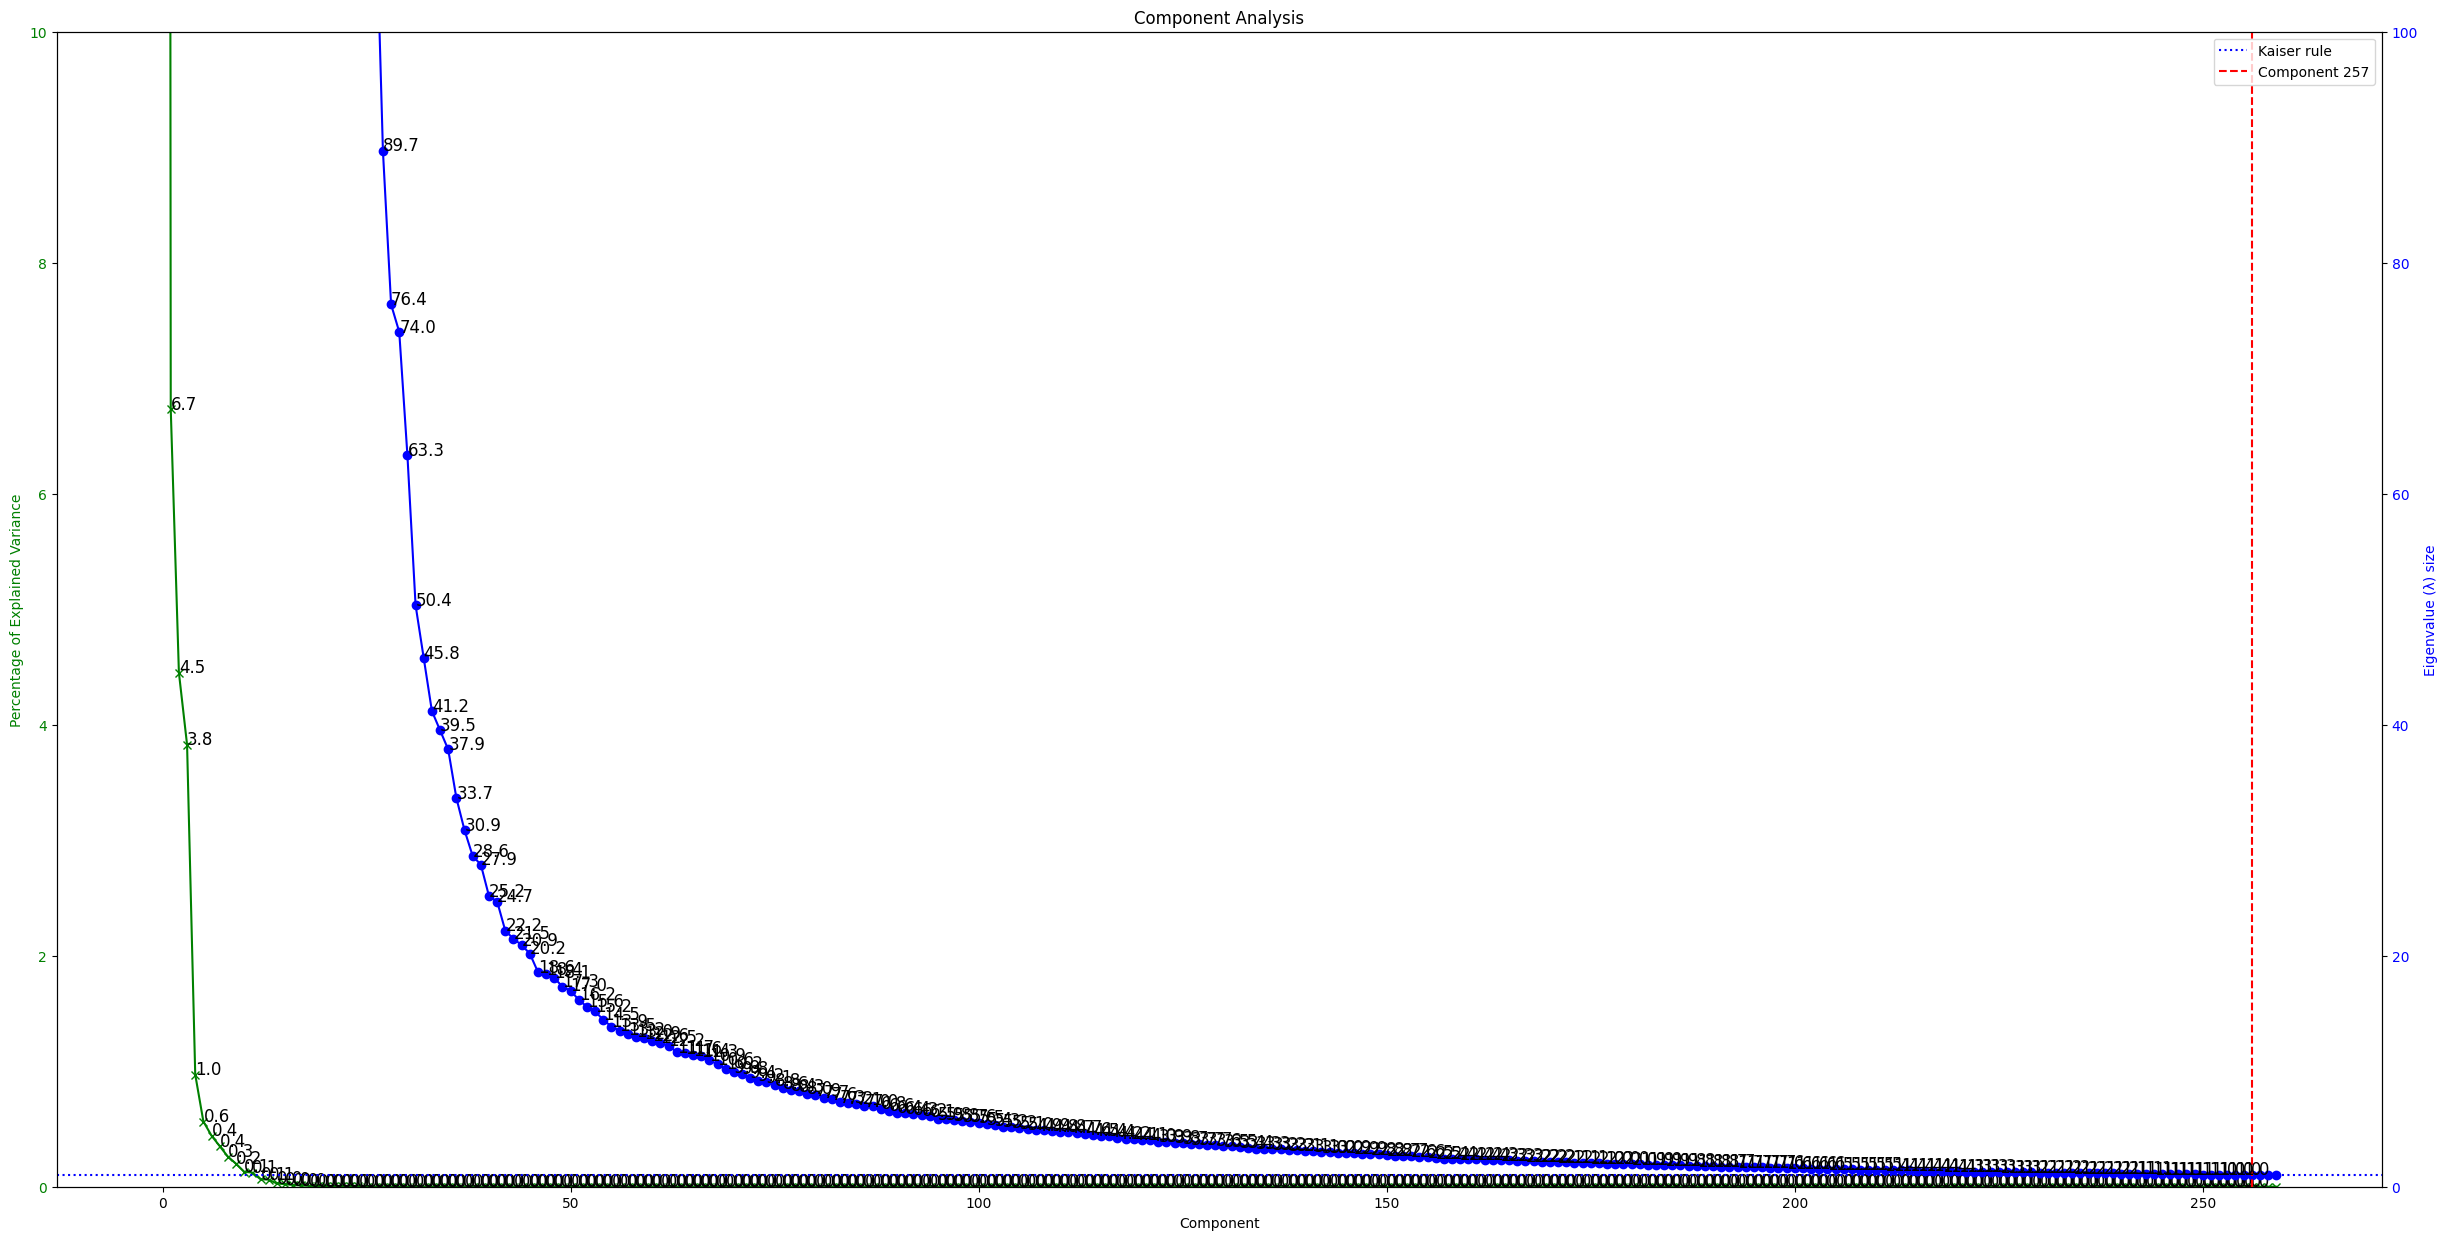

Amount of variance explained by 256 components s.t. λ_component > 1: 99.99999999999999%


In [184]:
# Linear PCA
pca = PCA(n_components=260, svd_solver="full")
pca_results = pca.fit_transform(images)

color_var = "#008000"
color_eig = "#0000FF"
cutoff = 1
ylim = 10
fig, ax_var = plt.subplots(figsize=(30,15))
ax_eig = ax_var.twinx()
ax_var.set_xlabel("Component")
ax_var.set_title("Component Analysis")
ax_var.set_ylim(0, ylim)
ax_eig.set_ylim(0, ylim * 10)

ax_var.plot(pca.explained_variance_ratio_ * 100, marker="x", color=color_var)
ax_var.set_ylabel('Percentage of Explained Variance', color=color_var)
ax_var.tick_params(axis="y", labelcolor=color_var)

ax_eig.plot(pca.explained_variance_, marker="o", color=color_eig)
ax_eig.set_ylabel("Eigenvalue (λ) size", color=color_eig)
ax_eig.tick_params(axis="y", labelcolor=color_eig)
ax_eig.axhline(y=cutoff, linestyle=":", label="Kaiser rule", color=color_eig)

intersection = np.argwhere(np.diff(np.sign(cutoff - pca.explained_variance_))).flatten()
if len(intersection) == 0:
    num_components = len(pca.explained_variance_)
else:
    num_components = intersection[0] - 1
    ax_eig.axvline(x=num_components, linestyle="dashed", label="Component %d" %(num_components + 1), color="red")

linear_pca = PCA(n_components=num_components, svd_solver="full")
linear_pca_results = linear_pca.fit_transform(images)

sum = 0
for index in range(num_components):
    if(len(intersection) > 0):
        sum = sum + (pca.explained_variance_ratio_[index] * 100).round(1)
    if pca.explained_variance_ratio_[index] * 100 <= ylim:
        ax_var.text(index, pca.explained_variance_ratio_[index] * 100, (pca.explained_variance_ratio_[index] * 100).round(1), size=12)
    if pca.explained_variance_[index] <= ylim * 10:
        ax_eig.text(index, pca.explained_variance_[index], pca.explained_variance_[index].round(1), size=12)
    
ax_eig.legend(loc="upper right")
plt.show()
print("Amount of variance explained by " + str(num_components) + " components s.t. λ_component > 1: " + str(sum) + "%")

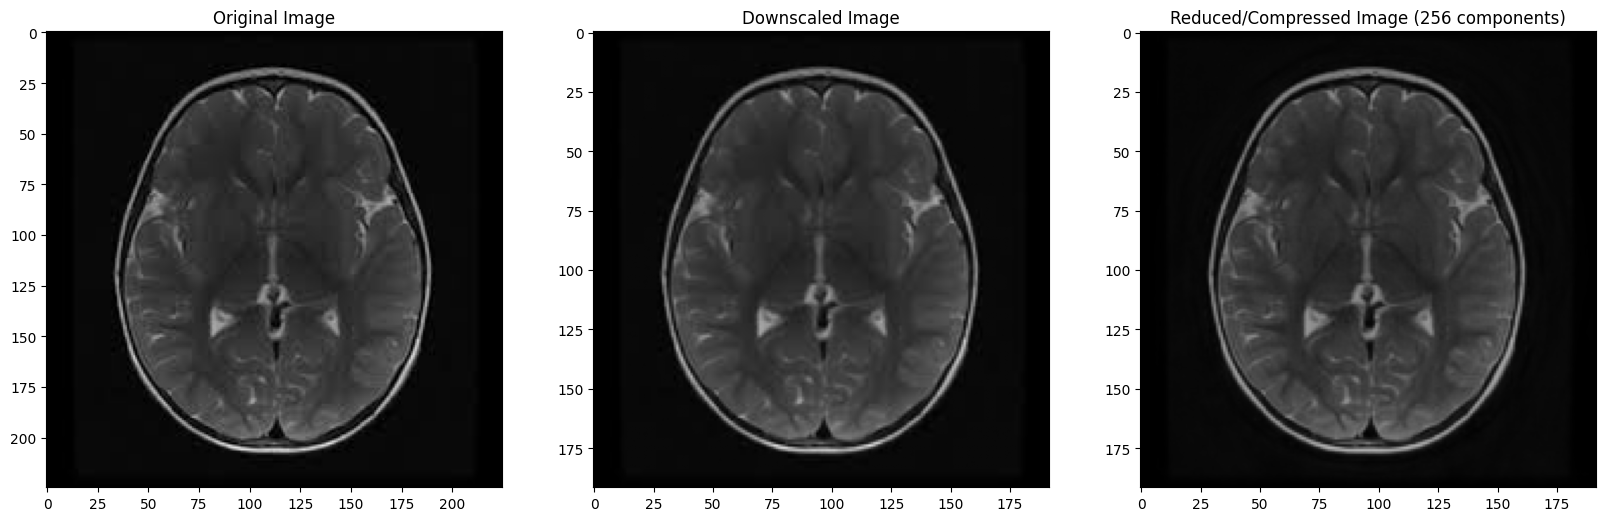

In [219]:
# Look at the randomly selected index 25 to see a different image for comparison
linear_imgs = linear_pca.inverse_transform(linear_pca_results)

fig, ax = plt.subplots(1, 3, figsize=(20,10))
ax[0].imshow(cancer_images[25], cmap='gray')
ax[0].set_title("Original Image")
ax[1].imshow(images[25].reshape(192, 192, 3), cmap='gray')
ax[1].set_title("Downscaled Image")
ax[2].imshow(np.clip(linear_imgs[25].reshape(192,192,3), 0, 1), cmap="gray")
ax[2].set_title("Reduced/Compressed Image (" + str(num_components) + " components)")
plt.show()

In [63]:
# Random PCA

In [64]:
# Comparisons go here, interspace these sections with analysis